In [1]:
%%capture
!pip install -U tensorflow-text
!pip install tf-models-official

In [2]:
import os
import shutil
from pathlib import Path

import tensorflow as tf
import tensorflow_hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import datetime

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = Path('.') / 'aclImdb'
train_dir = Path(dataset_dir) / 'train'
test_dir = Path(dataset_dir) / 'test'

remove_dir = Path(train_dir) / 'unsup'
shutil.rmtree(remove_dir)

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)



84125825/84125825 [==============================] - 5s 0us/step
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Overview of the reviews:

In [4]:
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'Stupid and just plain weird movie about some kid who becomes traumatized when he finds out Santa isn\'t real (???). He grows up and becomes an adult (Brandon Maggart) who makes lists of people who are naughty or nice. One Christmas he snaps and sets out to kill the naughty people--dressed as Santa of course.<br /><br />Boring and just plain bad killer Santa movie. If you\'re looking for gore, it\'s not here. Only a few of the murders are shown and they\'re not that gory with VERY fake effects. Most of the movie just contains Brandon Maggart talking to himself and slowly going crazy. The script is trite, the acting is terrible and it leads to an ending which had me staring slack-jawed at the TV. Seriously, I had to rewind the tape and watch it again to make sure I wasn\'t hallucinating! Really REALLY poor ending.<br /><br />If you want a scary Christmas flick rent "Black Christmas" (the original 70s version---NOT the terrible remake). Avoid this one at all costs.'
Label : 0 (n

Building the model:

In [5]:
#tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3' # BERT model
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1' # small BERT model
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3'
bert_preprocess_model = tensorflow_hub.KerasLayer(tfhub_handle_preprocess)

sentence = ['I like nlp']
text_preprocessed = bert_preprocess_model(sentence)

print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Shape      : (1, 128)
Word Ids   : [ 101  146 1176  183 1233 1643  102    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
bert_model = tensorflow_hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999982   0.081607   -0.9971956   0.01151122 -0.9965372  -0.10179879
 -0.91629314 -0.726131    0.16070108 -0.15485592 -0.1403125  -0.09926453]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-1.247094   -0.348022   -2.8169596  ... -1.0223976  -0.5486642
   0.4155478 ]
 [-1.3511565  -1.3228742   0.63541454 ... -0.9826267  -1.5024691
   1.1037158 ]
 [-1.9130938  -0.85812074  0.33952504 ... -2.4654903  -1.1236168
   1.3087872 ]
 ...
 [-1.2427813  -1.431713    0.31718177 ... -1.5987799  -0.8911335
   0.88397235]
 [-1.0035266  -1.31159     0.27349642 ... -1.4690684  -0.95014274
   0.73115623]
 [-0.9430742  -1.1566832   0.39200246 ... -1.224145   -1.1596254
   0.5896002 ]]


Bert Classifier:

In [7]:
def bert_classifier():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = tensorflow_hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = tensorflow_hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [8]:
model = bert_classifier()
bert_raw_result = model(tf.constant(sentence))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.2138686]], shape=(1, 1), dtype=float32)


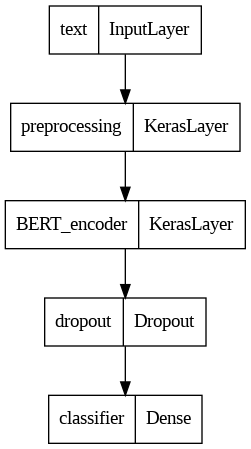

In [9]:
tf.keras.utils.plot_model(model)

In [10]:
# Loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

# Optimizer
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [11]:
CHECKPOINT_DIR = './BERT_training_checkpoints'
CHECKPOINT_PREFIX = Path(CHECKPOINT_DIR) / "checkpoint_{epoch}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PREFIX,
    monitor='val_accuracy',
    mode='max')

In [15]:
MODEL_NAME = f'BERT-{datetime.datetime.now():%Y%m%d-%H%M%S}'

CHECKPOINT_DIR = './' + MODEL_NAME
CHECKPOINT_PREFIX = Path(CHECKPOINT_DIR) / "checkpoint_{epoch}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PREFIX,
    monitor='val_accuracy',
    mode='max')

tensorboard = tf.keras.callbacks.TensorBoard(
                            log_dir=f'./tensorboardlogs/{MODEL_NAME}',
                            write_graph=True,
                            write_images=True,
                            histogram_freq=1)

In [ ]:
callbacks = [
                checkpoint,
                tensorboard
]

hist = model.fit(
              train_ds,
              epochs=epochs,
              validation_data=val_ds,
              callbacks=callbacks).history